# Seasonal flux totals vs SPEI

This is an examination of how seasonal flux totals relate to SPEI on an interannual basis. Still a work in progress. May be good to add regression lines to the plots. Also need to add 2015 data.

In [48]:
# Greg Maurer - August 2015
# Edited and expanded on by Alex Moody - 2017

library(ggplot2)
library(plyr)
library(reshape2)

theme_set(theme_bw())

setwd('C:/Code/NMEG_miscellany/')

proc_path <- 'processed_data/'
outpath <- 'figures/'

source('C:/Code/NMEG_utils/r_functions/printfigs.r')
source('C:/Code/NMEG_utils/r_functions/load_nmeg.r')
source('C:/Code/NMEG_utils/r_functions/transform_nmeg.r')
#source('load_datasets.r')

# Get flux datasets
seg <- get_daily_file('Seg', 'aflx', make_new=FALSE)
ses <- get_daily_file('Ses', 'aflx')
wjs <- get_daily_file('Wjs', 'aflx')
mpj <- get_daily_file('Mpj', 'aflx')
vcp <- get_daily_file('Vcp', 'aflx')
vcm <- get_daily_file('Vcm', 'aflx')
# Put together one-variable dataframes with season columns and such
sitelist <- list(seg, ses, wjs, mpj, vcp, vcm)
sitenames <- c('Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm')
FC_daily <- get_var_allsites(sitelist, 'FC_F_g_int', sitenames, startyear=2007, endyear=2017)
GPP_daily <- get_var_allsites(sitelist, 'GPP_g_int', sitenames, startyear=2007, endyear=2017)
RE_daily <- get_var_allsites(sitelist, 'RECO_g_int', sitenames, startyear=2007, endyear=2017)
ET_daily <- get_var_allsites(sitelist, 'ET_mm_dayint', sitenames, startyear=2007, endyear=2017)
# Calculate some derived values
# Water use efficiency
WUE_daily <- cbind(ET_daily[1], GPP_daily[-1]/ET_daily[-1])
# Carbon use efficiency
CUE_daily <- cbind(FC_daily[1], FC_daily[-1]/GPP_daily[-1])
# Respiration/GPP Ratio
RdivGPP_daily <- cbind(FC_daily[1], RE_daily[-1]/GPP_daily[-1])
head(FC_daily)
head(GPP_daily)
head(CUE_daily)
head(RdivGPP_daily)

date,Seg,Ses,Wjs,Mpj,Vcp,Vcm
2007-01-01,0.59240886,0.44655096,NA,NA,0.11145568,0.01794237
2007-01-02,0.86964580,0.40673870,NA,NA,0.05482807,0.53166867
2007-01-03,0.67098457,0.46637642,NA,NA,-0.26368663,0.17466293
2007-01-04,0.44611509,0.14408511,NA,NA,-0.12266828,0.11154777
2007-01-05,0.05641652,0.07220382,NA,NA,-0.04977321,0.03578328
2007-01-06,0.59988679,0.27810039,NA,NA,-0.63123165,0.45469259


date,Seg,Ses,Wjs,Mpj,Vcp,Vcm
2007-01-01,0.0147163255,0.12387202,NA,NA,0.2513389,0.19789498
2007-01-02,0.0040316927,0.01392660,NA,NA,0.3723671,0.04457147
2007-01-03,0.0001968029,0.02692141,NA,NA,0.6495985,0.31961458
2007-01-04,0.1514145006,0.38351161,NA,NA,0.8722631,0.38733143
2007-01-05,0.2284160322,0.73369235,NA,NA,0.4100251,0.23242177
2007-01-06,0.0253080968,0.10909851,NA,NA,0.9236567,0.05763250


date,Seg,Ses,Wjs,Mpj,Vcp,Vcm
2007-01-01,40.2552160,3.60493817,NA,NA,0.4434479,0.09066612
2007-01-02,215.7023994,29.20587906,NA,NA,0.1472420,11.92845261
2007-01-03,3409.4245790,17.32362798,NA,NA,-0.4059225,0.54647986
2007-01-04,2.9463169,0.37569948,NA,NA,-0.1406322,0.28799049
2007-01-05,0.2469902,0.09841157,NA,NA,-0.1213906,0.15395837
2007-01-06,23.7033545,2.54907609,NA,NA,-0.6834051,7.88951641


date,Seg,Ses,Wjs,Mpj,Vcp,Vcm
2007-01-01,41.255216,4.604938,NA,NA,1.4434479,1.090666
2007-01-02,216.702399,30.205879,NA,NA,1.1472420,12.928453
2007-01-03,3410.424579,18.323628,NA,NA,0.5940775,1.546480
2007-01-04,3.946317,1.375699,NA,NA,0.8593678,1.287990
2007-01-05,1.246990,1.098412,NA,NA,0.8786094,1.153958
2007-01-06,24.703354,3.549076,NA,NA,0.3165949,8.889516


In [45]:
# Function to clean up unused columns and rename variables
clean_rename <- function(df, keep=c("season", "year_w", sitenames)){
    df_c_r <- add_WY_cols(df)
    df_c_r <- subset(df_c_r, subset = (year_w > 2007 & year_w < 2017))
    #print(head(df_c_r))
    #print(tail(df_c_r))
    df_c_r <- df_c_r[, keep]
    #df_c_r <- rename_vars(df_c_r)
    df_c_r$season <- revalue(df_c_r$season, c("cold"="Cold",
                            "monsoon"="Monsoon",
                            "spring"="Spring"))
    reorder <- c('Cold', 'Spring', 'Monsoon')
    df_c_r$season <- factor(df_c_r$season, levels=reorder)
    return(df_c_r)
}

In [46]:
SPEI_path <- 'C:/Code/NMEG_utils/processed_data/spei/'
seg_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Seg_nainterp.csv', sep=''))
ses_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Ses_nainterp.csv', sep=''))
wjs_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Wjs_nainterp.csv', sep=''))
mpj_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Mpj_nainterp.csv', sep=''))
vcp_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Vcp_nainterp.csv', sep=''))
vcm_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Vcm_nainterp.csv', sep=''))

sitelist <- list(seg_spei, ses_spei, wjs_spei, mpj_spei, vcp_spei, vcm_spei)
spei_1yr <- get_var_allsites(sitelist, 'SPEI_monthly_12', sitenames, startyear=2006, endyear=2016)

# Add WY columns and clean data
spei_1yr <- clean_rename(spei_1yr)

# Melt and get seasonal SPEI averages for each year
spei_melt <- melt(spei_1yr, id.vars=c('season', 'year_w'))

spei_seas_avg <- ddply(spei_melt, .(variable, season, year_w), summarise, seas_mean_spei = mean(value, na.rm = T))
head(spei_seas_avg)

# Melt and get wateryear SPEI averages (leave out season)
spei_melt <- melt(spei_1yr[,2:ncol(spei_1yr)], id='year_w')
spei_wyear_avg <- ddply(spei_melt, .(variable, year_w), summarise, wyear_mean_spei = mean(value, na.rm = T))

#spei_wyear_avg

# Clean, melt, get average
et_1yr <-clean_rename(ET_daily)

et_melt <- melt(et_1yr[,2:ncol(et_1yr)], id.vars=c('year_w'))
head(et_melt)
et_wyear_int <- ddply(et_melt, .(variable, year_w), summarise, wyear_int_et = cumsum(value))
head(et_wyear_int)
write.csv(et_wyear_int, paste(SPEI_path, 'SPEI_vs_ET2.csv', sep=''))

et_wyear_avg <- ddply(et_melt, .(variable, year_w), summarise, wyear_mean_et = mean(value, na.rm = T))

variable,season,year_w,seas_mean_spei
Seg,Cold,2008,-1.41082836
Seg,Cold,2009,-0.51169583
Seg,Cold,2010,0.53175662
Seg,Cold,2011,-0.20812857
Seg,Cold,2012,-0.46332131
Seg,Cold,2013,0.02718266


year_w,variable,value
2008,Seg,0.5241862
2008,Seg,0.2986248
2008,Seg,0.2691467
2008,Seg,0.3698545
2008,Seg,1.4596507
2008,Seg,0.5292703


variable,year_w,wyear_int_et
Seg,2008,0.5241862
Seg,2008,0.8228110
Seg,2008,1.0919577
Seg,2008,1.4618122
Seg,2008,2.9214629
Seg,2008,3.4507333


## NEE 

variable,season,year_w,seas_sum
Seg,Cold,2008,28.28145
Seg,Cold,2009,20.55216
Seg,Cold,2010,29.24064
Seg,Cold,2011,29.83489
Seg,Cold,2012,28.38568
Seg,Cold,2013,37.75624


'data.frame':	162 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  28.3 20.6 29.2 29.8 28.4 ...
 $ spei_seas: num  -1.411 -0.512 0.532 -0.208 -0.463 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  28.3 20.6 29.2 29.8 28.4 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


Warning message:
"Removed 3 rows containing missing values (geom_point)."

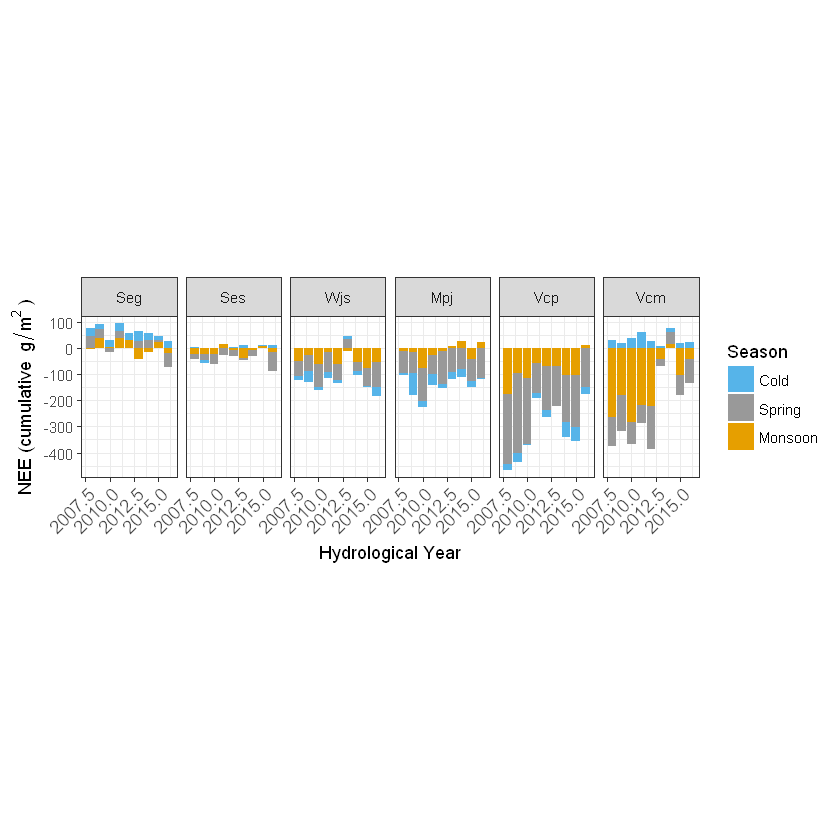

Warning message:
"Removed 3 rows containing missing values (geom_point)."

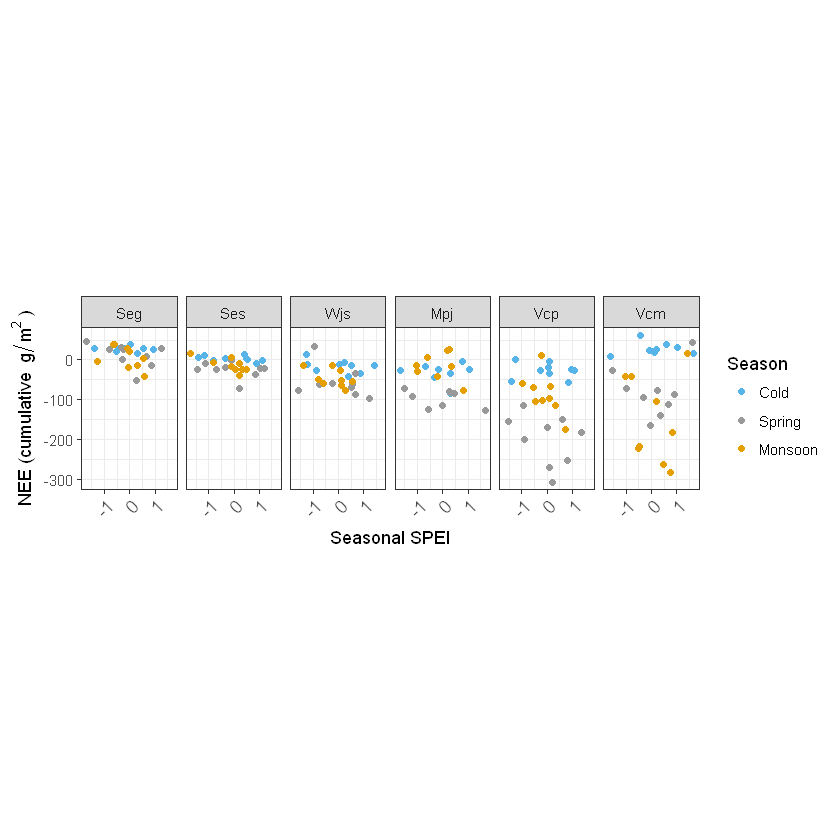

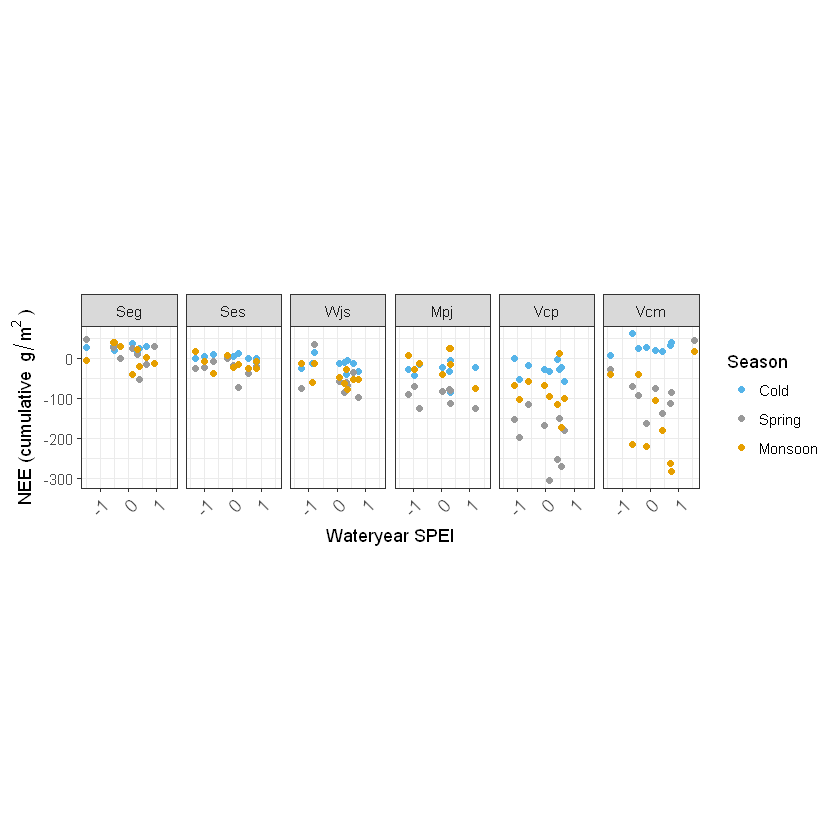

In [31]:
asp_ratio <- 1.7

FC.m <- melt(clean_rename(FC_daily), id.vars=c('season', 'year_w'))
FC.m <- ddply(FC.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(FC.m)
FC.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(FC.m)

# Merge in the annual values of SPEI
FC.m <- merge(FC.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
FC.m <- FC.m[with(FC.m, order(variable, season, year_w)),]
str(FC.m)

NEE_seas_by_yr <- ggplot(FC.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Hydrological Year') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_yr
#ggsave("C:/Research_Flux_Towers/Plots/multiyear_figs/NEE_seas_by_yr.png", dpi = 150 )


NEE_seas_by_spei <- ggplot(FC.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity', position='dodge') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_spei
#ggsave("C:/Research_Flux_Towers/Plots/multiyear_figs/NEE_seas_by_spei.png", dpi = 150 )

NEE_seas_by_annspei <- ggplot(FC.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_annspei
#ggsave("C:/Research_Flux_Towers/Plots/multiyear_figs/NEE_seas_by_annspei.png", dpi = 150 )

## GPP

variable,season,year_w,seas_sum
Seg,Cold,2008,27.58594
Seg,Cold,2009,16.16741
Seg,Cold,2010,14.16724
Seg,Cold,2011,19.85327
Seg,Cold,2012,16.17839
Seg,Cold,2013,16.34676


'data.frame':	162 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  27.6 16.2 14.2 19.9 16.2 ...
 $ spei_seas: num  -1.411 -0.512 0.532 -0.208 -0.463 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  27.6 16.2 14.2 19.9 16.2 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


Warning message:
"Removed 3 rows containing missing values (geom_point)."

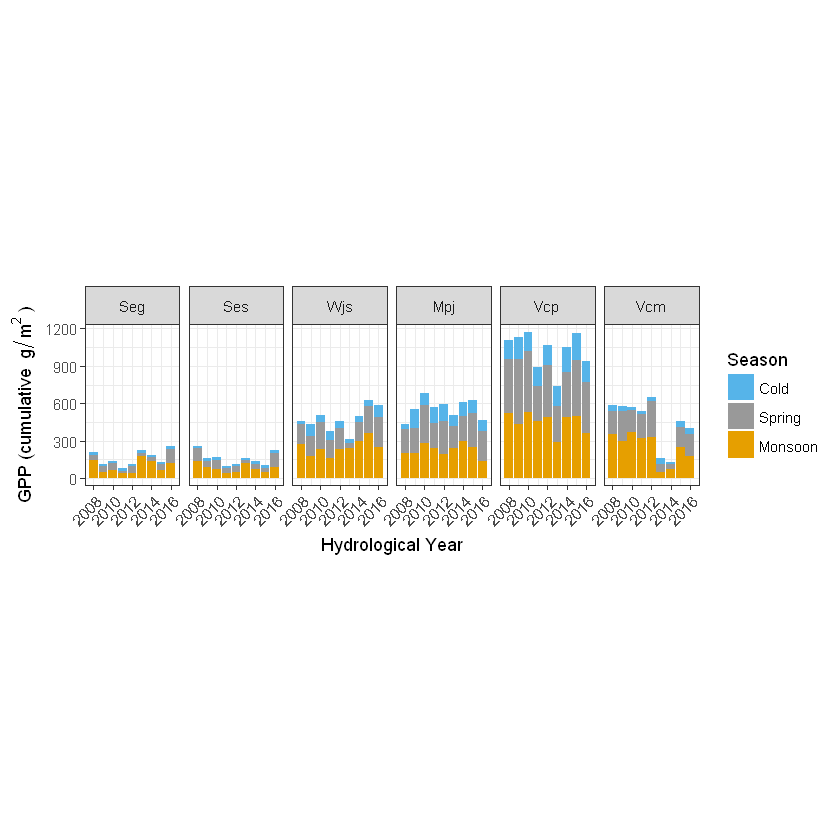

Warning message:
"Removed 3 rows containing missing values (geom_point)."

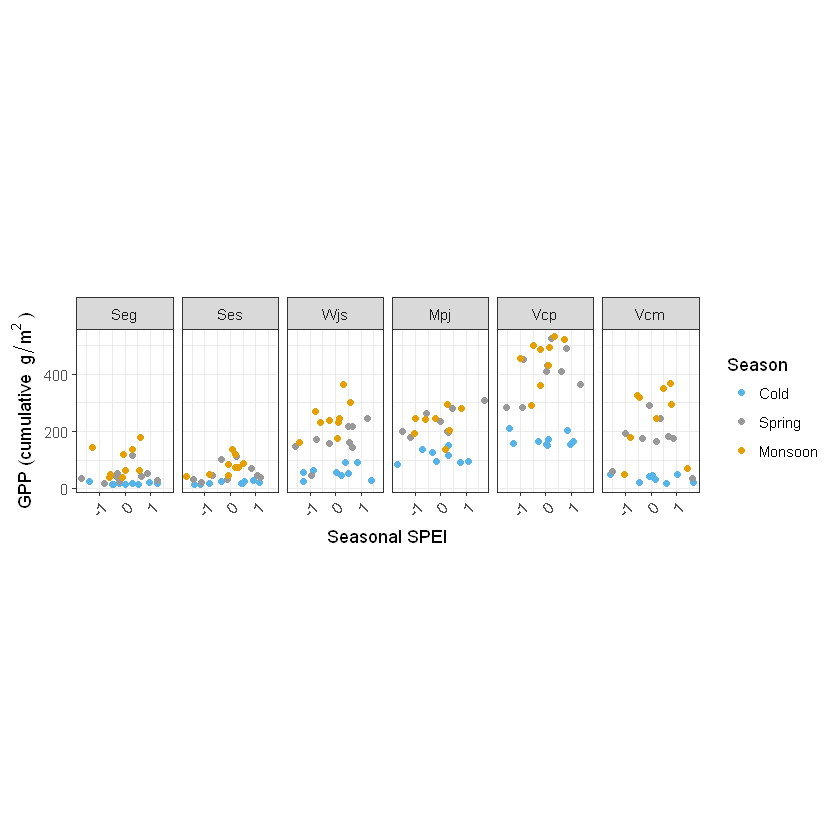

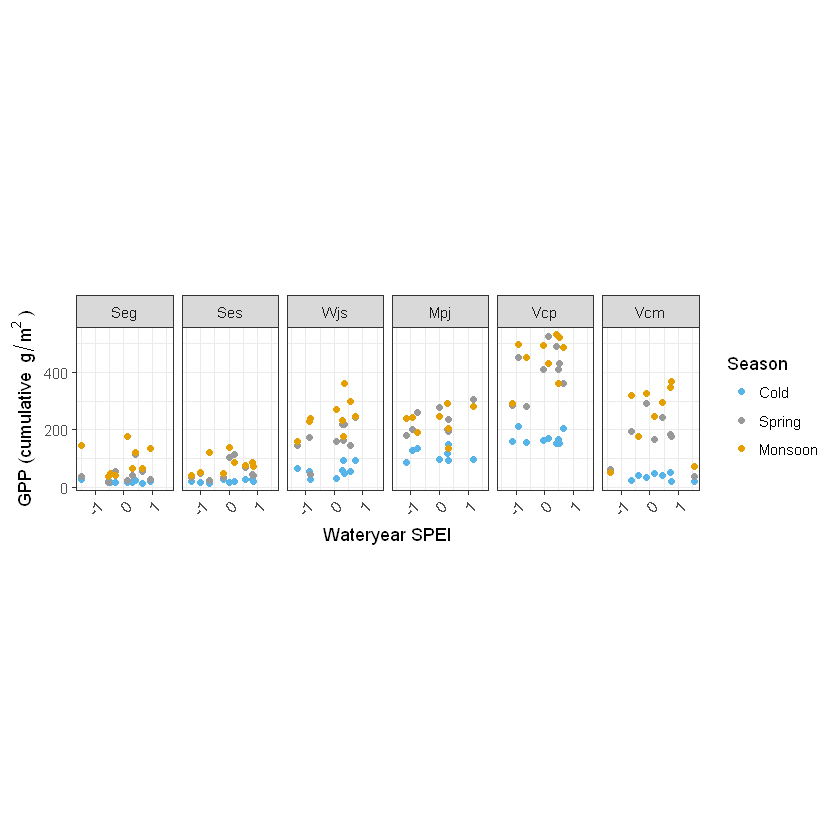

In [32]:
GPP.m <- melt(clean_rename(GPP_daily), id.vars=c('season', 'year_w'))
GPP.m <- ddply(GPP.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(GPP.m)
GPP.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(GPP.m)
# Merge in the annual values of SPEI
GPP.m <- merge(GPP.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
GPP.m <- GPP.m[with(GPP.m, order(variable, season, year_w)),]
str(GPP.m)

GPP_seas_by_yr <- ggplot(GPP.m, aes(x=year_w, y=seas_sum, fill=season)) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Hydrological Year') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    scale_x_continuous(breaks=seq(2008,2016,2)) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=9)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_yr


GPP_seas_by_seasspei <- ggplot(GPP.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=9)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_seasspei

GPP_seas_by_annspei <- ggplot(GPP.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=9)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_annspei

In [33]:
# Plot stacked bars but ordered by annual spei
GPP.m$year_w_f <- as.factor(GPP.m$year_w)
#siteyear <- apply(GPP.m[,c('variable', 'year_w')], 1, paste, collapse=" ")
#test <- as.factor(siteyear)
#levels(test)
GPP.m$rank_spei_bysite <- ave( GPP.m$wyear_mean_spei,  as.factor(GPP.m$variable), FUN=rank)
GPP.m[20:29,]
#test3
#length(test3)
#GPP.m <- GPP.m[with(GPP.m, order(variable, season, wyear_mean_spei)),]
#GPP.m$year_w_f <- reorder(GPP.m$year_w_f, GPP.m$wyear_mean_spei)
#levels(GPP.m$year_w_f)
GPP_seas_by_annspei2 <- ggplot(order_by(year_w_f, ~wyear_mean_spei, GPP.m), aes(x=year_w_f, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    #geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Year, ordered by mean SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=7)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    scale_x_discrete(limits=c('2', '5', '8', '11', '14', '17', '20')) +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_annspei2

,variable,year_w,season,seas_sum,spei_seas,wyear_mean_spei,year_w_f,rank_spei_bysite
31,Seg,2009,Monsoon,49.26502,-0.589126982,-0.48033199,2009,8
34,Seg,2010,Monsoon,64.22998,0.545396161,0.64922886,2010,23
37,Seg,2011,Monsoon,38.47805,-0.631387900,-0.54456667,2011,5
42,Seg,2012,Monsoon,40.08895,-0.094451903,-0.28185893,2012,11
43,Seg,2013,Monsoon,178.73835,0.599071366,0.12881134,2013,14
46,Seg,2014,Monsoon,136.86087,0.287297962,0.93598606,2014,26
49,Seg,2015,Monsoon,66.03030,-0.005076937,0.31769689,2015,17
54,Seg,2016,Monsoon,120.65199,-0.054687222,0.39333298,2016,20
55,Ses,2008,Cold,18.05080,0.487635215,0.02769321,2008,14
60,Ses,2009,Cold,28.67822,0.899839982,0.82117188,2009,23


ERROR: Error in ggplot(order_by(year_w_f, ~wyear_mean_spei, GPP.m), aes(x = year_w_f, : could not find function "order_by"


variable,season,year_w,seas_sum
Seg,Cold,2008,55.86739
Seg,Cold,2009,36.71957
Seg,Cold,2010,43.40788
Seg,Cold,2011,49.68816
Seg,Cold,2012,44.56407
Seg,Cold,2013,54.10300


'data.frame':	162 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  55.9 36.7 43.4 49.7 44.6 ...
 $ spei_seas: num  -1.411 -0.512 0.532 -0.208 -0.463 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  55.9 36.7 43.4 49.7 44.6 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


Warning message:
"Removed 3 rows containing missing values (geom_point)."

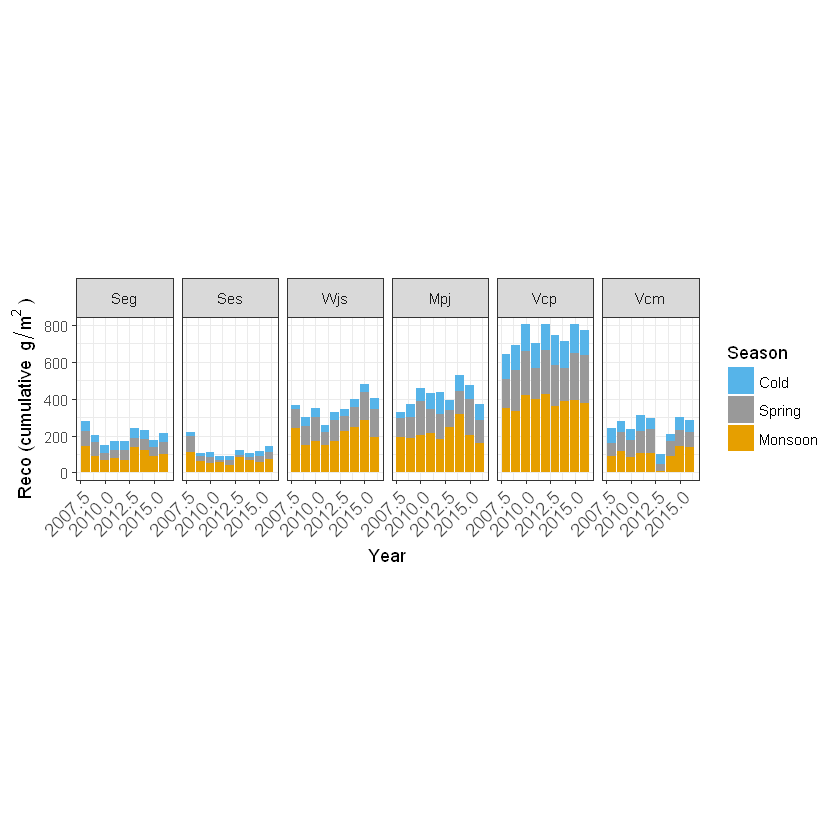

Warning message:
"Removed 3 rows containing missing values (geom_point)."

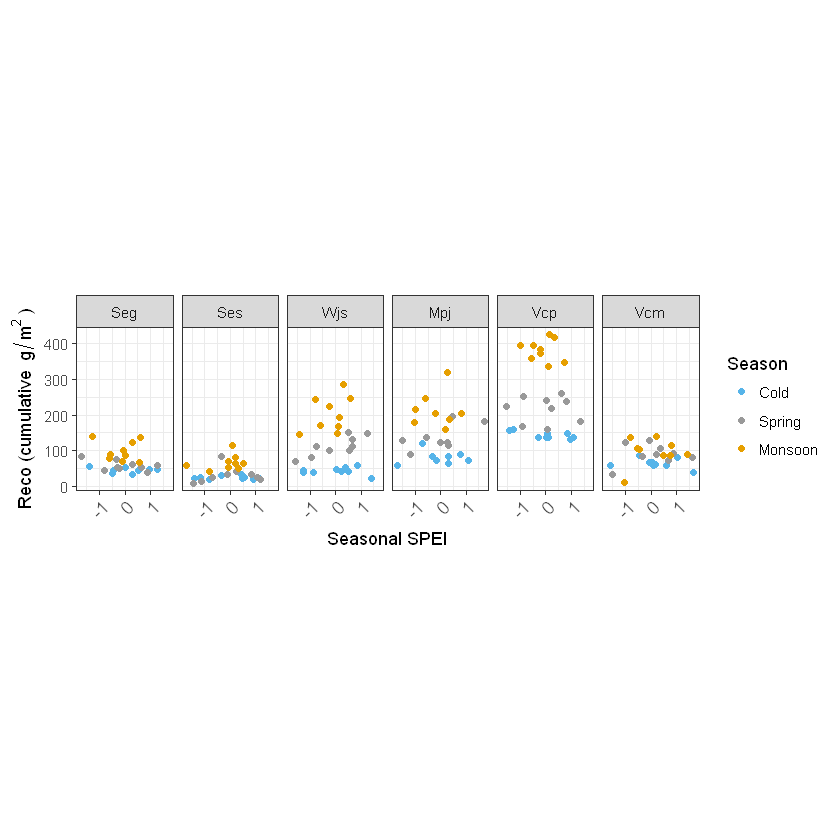

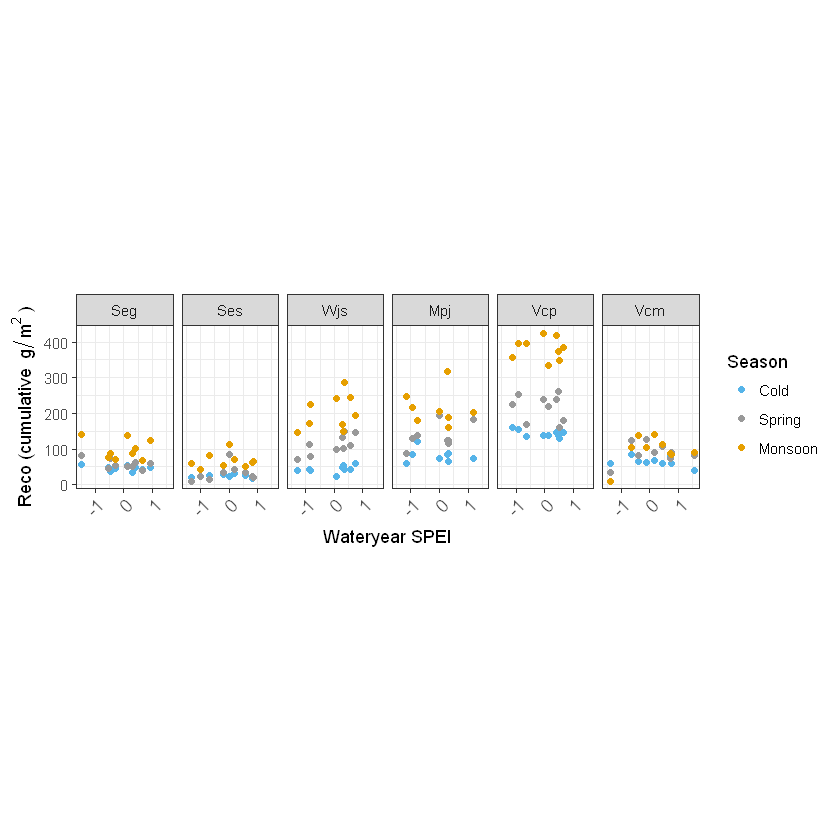

In [34]:

RE.m <- melt(clean_rename(RE_daily), id.vars=c('season', 'year_w'))
RE.m <- ddply(RE.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(RE.m)
RE.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(RE.m)
# Merge in the annual values of SPEI
RE.m <- merge(RE.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
RE.m <- RE.m[with(RE.m, order(variable, season, year_w)),]
str(RE.m)

RE_seas_by_yr <- ggplot(RE.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_yr

RE_seas_by_spei <- ggplot(RE.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_spei

RE_seas_by_annspei <- ggplot(RE.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_annspei

variable,season,year_w,seas_sum
Seg,Cold,2008,32.17136
Seg,Cold,2009,27.95877
Seg,Cold,2010,45.86943
Seg,Cold,2011,23.08909
Seg,Cold,2012,41.43810
Seg,Cold,2013,23.78271


'data.frame':	162 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  32.2 28 45.9 23.1 41.4 ...
 $ spei_seas: num  -1.411 -0.512 0.532 -0.208 -0.463 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  32.2 28 45.9 23.1 41.4 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


variable,year_w,year_sum
Seg,2008,241.5759
Seg,2009,213.7015
Seg,2010,244.9123
Seg,2011,140.9081
Seg,2012,218.8078
Seg,2013,214.9186


'data.frame':	54 obs. of  3 variables:
 $ variable: Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w  : num  2008 2009 2010 2011 2012 ...
 $ year_sum: num  242 214 245 141 219 ...
'data.frame':	54 obs. of  4 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 4 4 4 4 4 4 4 4 4 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ year_sum       : num  251 297 410 258 305 ...
 $ wyear_mean_spei: num  NaN 0.32 1.194 -0.945 -0.769 ...


Warning message:
"Removed 3 rows containing missing values (geom_point)."

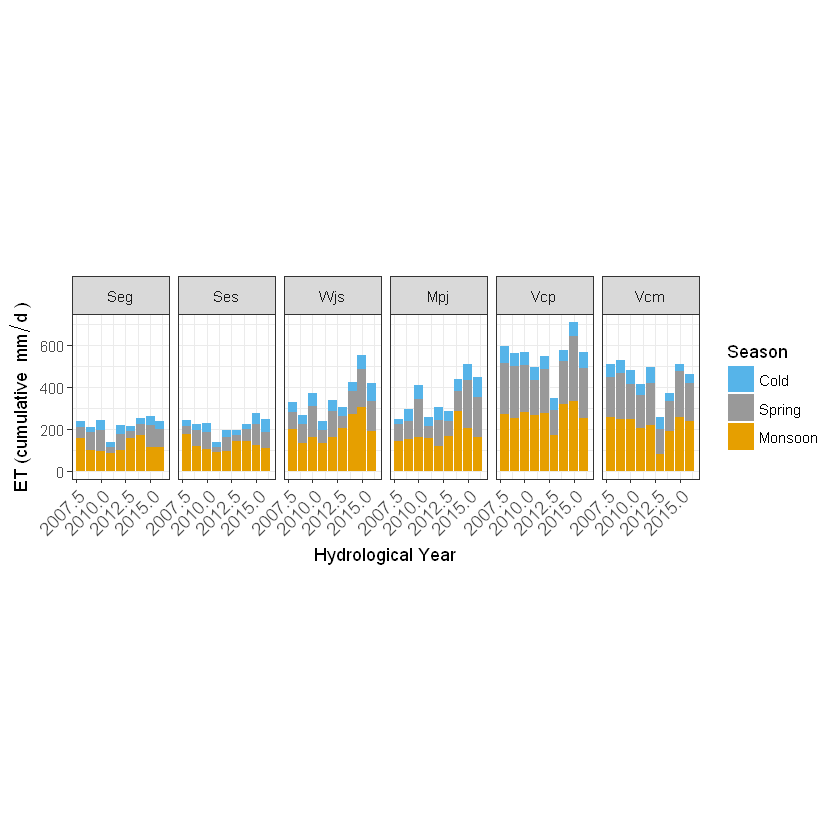

Warning message:
"Removed 3 rows containing missing values (geom_point)."

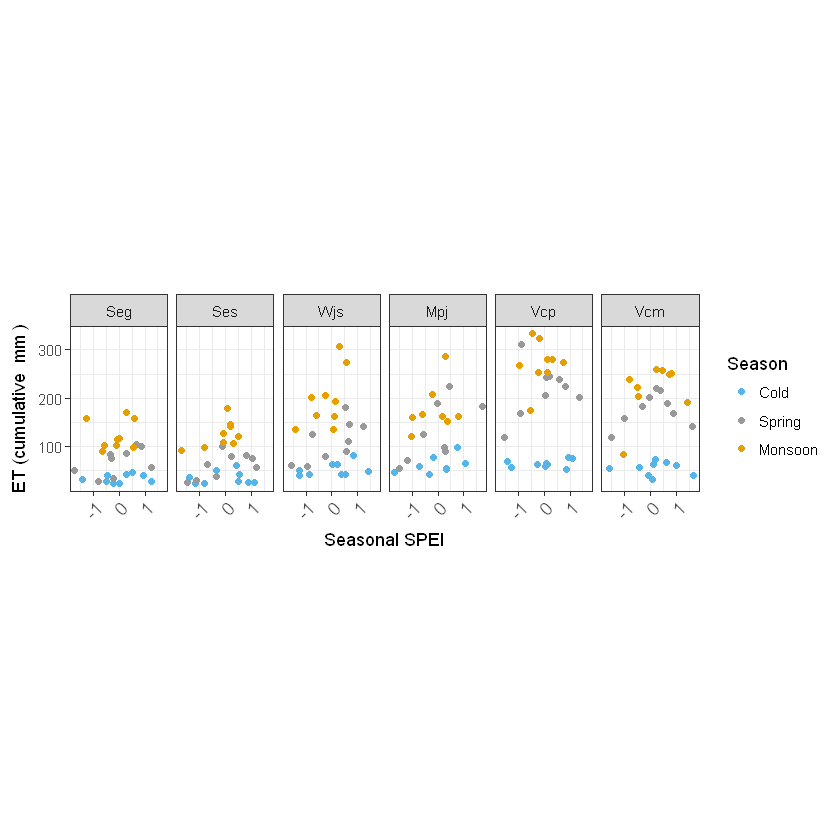

Warning message:
"Removed 3 rows containing missing values (geom_point)."

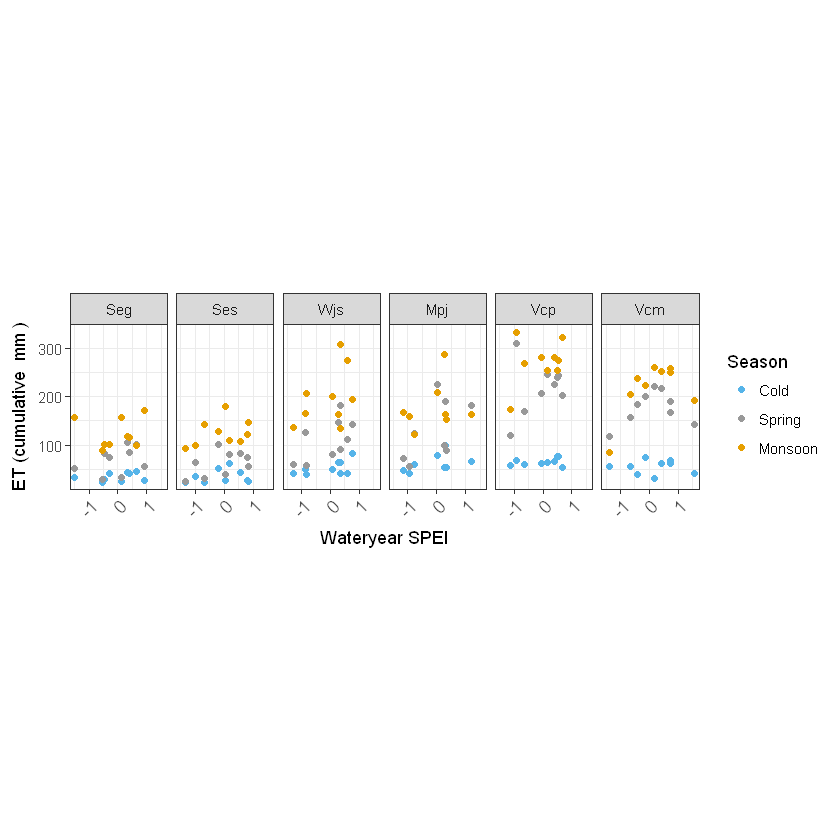

Warning message:
"Removed 1 rows containing missing values (geom_point)."

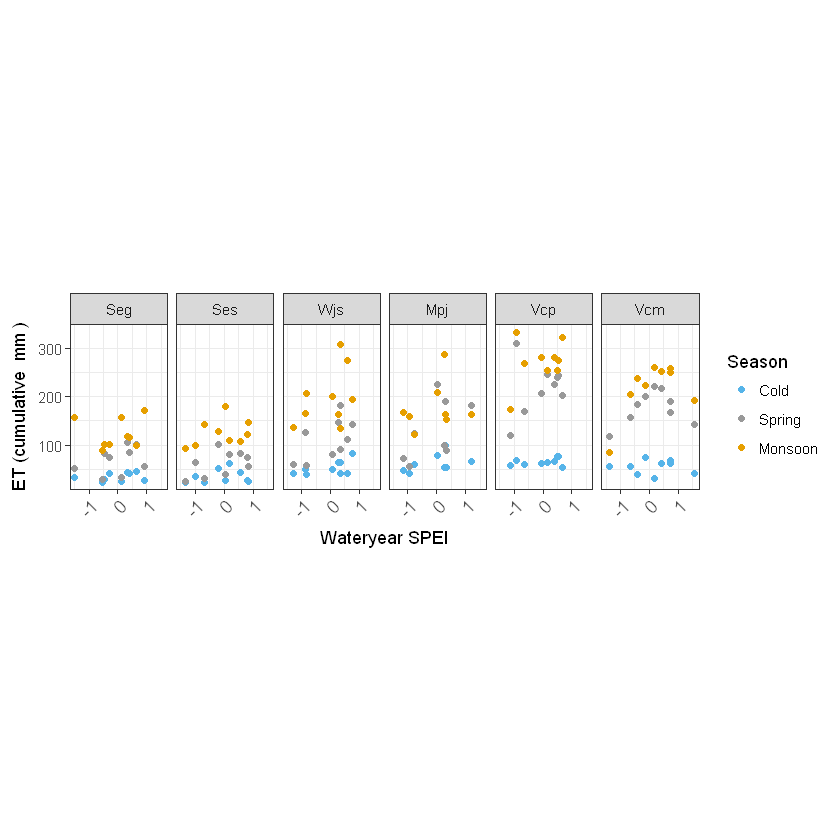

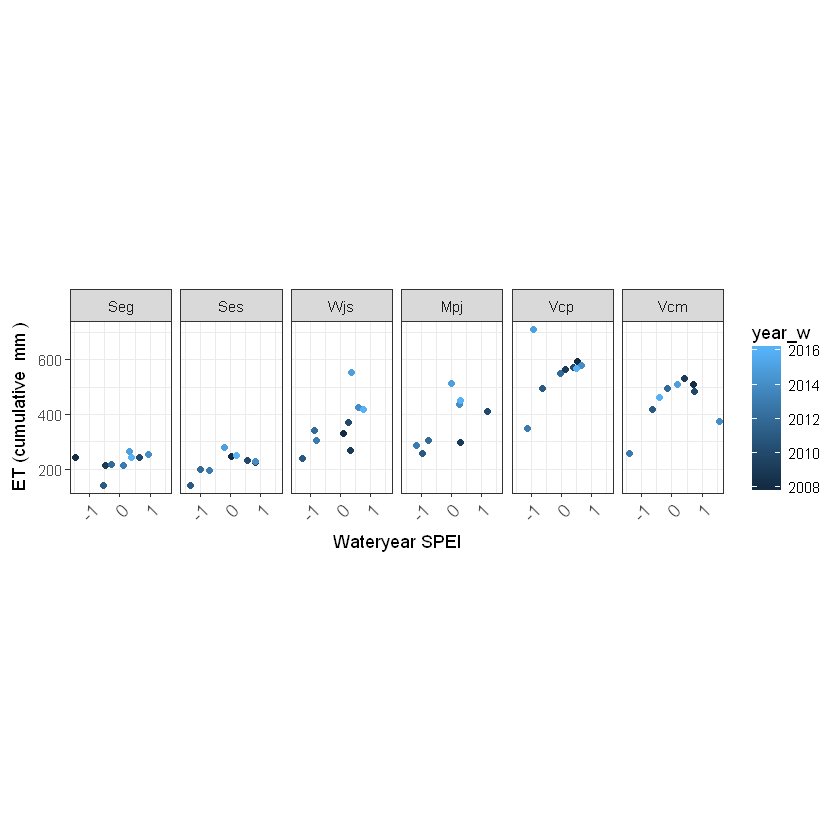

In [35]:
ET.m <- melt(clean_rename(ET_daily), id.vars=c('season', 'year_w'))
ET.m <- ddply(ET.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(ET.m)
ET.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(ET.m)
# Merge in the annual values of SPEI
ET.m <- merge(ET.m, spei_wyear_avg, by=c('variable', 'year_w'))

# The merge messes up the order - reorder it
ET.m <- ET.m[with(ET.m, order(variable, season, year_w)),]
str(ET.m)

# Make another dataframe for yearly values
ETyr.m <- melt(clean_rename(ET_daily), id.vars=c('season','year_w'))
ETyr.m <- ddply(ETyr.m, .(variable, year_w), summarise, year_sum = sum(value, na.rm = T))
head(ETyr.m)
str(ETyr.m)
# Merge in the annual values of SPEI
ETyr.m <- merge(ETyr.m, spei_wyear_avg, by=c('variable', 'year_w'))

# The merge messes up the order - reorder it
#ETyr.m <- ETyr.m[with(ET.m, order(variable, year_w)),]
str(ETyr.m)
#write.csv(ET.m, paste(SPEI_path, 'SPEI_vs_ET.csv', sep=''))

ET_seas_by_yr <- ggplot(ET.m, aes(x=year_w, y=seas_sum, fill=season)) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Hydrological Year') + ylab(bquote('ET (cumulative '~ mm/d ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
ET_seas_by_yr


ET_seas_by_seasspei <- ggplot(ET.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('ET (cumulative '~ mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
ET_seas_by_seasspei


ET_seas_by_annspei <- ggplot(ET.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('ET (cumulative '~ mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
ET_seas_by_annspei


ET_seas_by_annspei <- ggplot(ET.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('ET (cumulative '~ mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
ET_seas_by_annspei


ET_year_by_annspei <- ggplot(ETyr.m, aes(x=wyear_mean_spei, y=year_sum, col=year_w)) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('ET (cumulative '~ mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    #scale_color_manual(values=c("#CC6699", "#A35CA3", "#8F57A8", "#704FB0", "#5C4AB5", "#4745BA"), name="Year") +
    theme(aspect.ratio=asp_ratio)
ET_year_by_annspei


In [36]:
head(ETyr.m)
write.csv(ETyr.m, paste(SPEI_path, 'SPEI_vs_ET2.csv', sep=''))


variable,year_w,year_sum,wyear_mean_spei
Mpj,2008,250.8112,NaN
Mpj,2009,296.9349,0.3203842
Mpj,2010,410.3136,1.1943678
Mpj,2011,257.6525,-0.9448689
Mpj,2012,305.1239,-0.7692449
Mpj,2013,286.5958,-1.1613505


## Water use efficiency

,variable,year_w,season,seas_sum,spei_seas,wyear_mean_spei
28,Seg,2008,Cold,55.86739,-1.41082836,-1.4913828
33,Seg,2009,Cold,36.71957,-0.51169583,-0.4803320
36,Seg,2010,Cold,43.40788,0.53175662,0.6492289
39,Seg,2011,Cold,49.68816,-0.20812857,-0.5445667
40,Seg,2012,Cold,44.56407,-0.46332131,-0.2818589
45,Seg,2013,Cold,54.10300,0.02718266,0.1288113


'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  55.9 36.7 43.4 49.7 44.6 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  155.4 123.5 50.4 142.3 70.3 ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


Warning message:
"Removed 3 rows containing missing values (geom_point)."

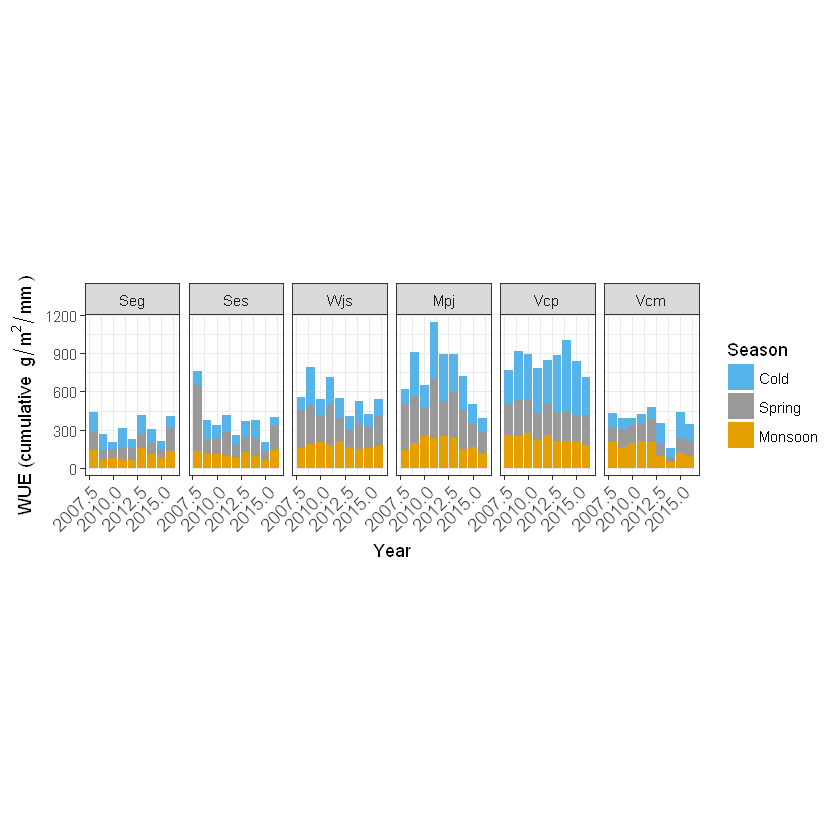

Warning message:
"Removed 3 rows containing missing values (geom_point)."

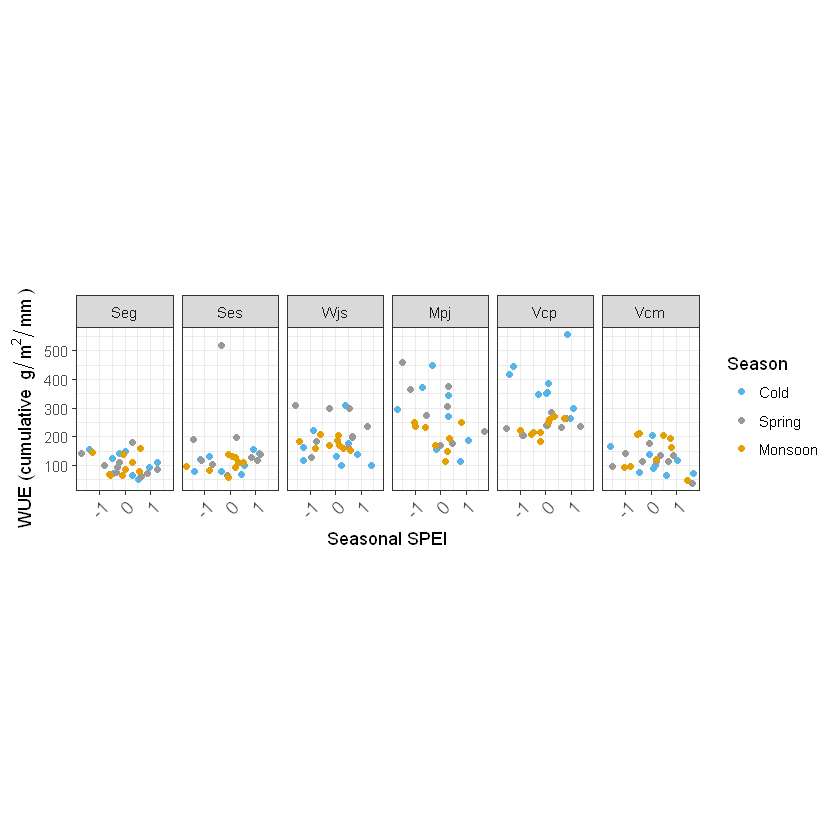

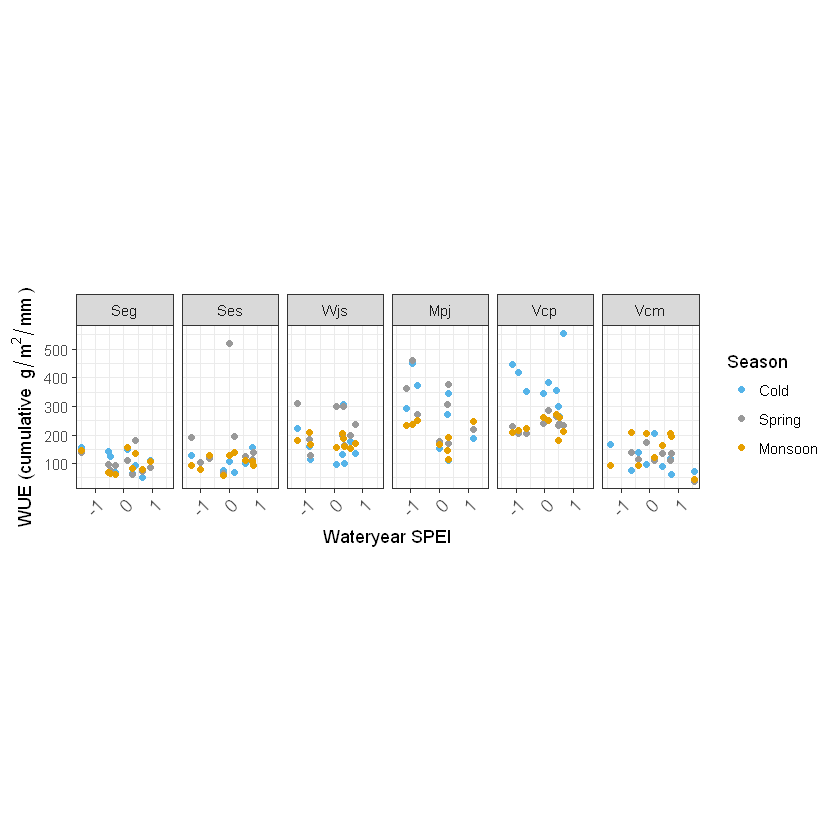

In [37]:
WUE.m <- melt(clean_rename(WUE_daily), id.vars=c('season', 'year_w'))
WUE.m <- ddply(WUE.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(RE.m)
WUE.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(RE.m)
# Merge in the annual values of SPEI
WUE.m <- merge(WUE.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
WUE.m <- WUE.m[with(WUE.m, order(variable, season, year_w)),]
str(WUE.m)

WUE_seas_by_yr <- ggplot(WUE.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('WUE (cumulative '~ g/m^2/mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
WUE_seas_by_yr

WUE_seas_by_spei <- ggplot(WUE.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('WUE (cumulative '~ g/m^2/mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
WUE_seas_by_spei

WUE_seas_by_annspei <- ggplot(WUE.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('WUE (cumulative '~ g/m^2/mm ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
WUE_seas_by_annspei

## Carbon Use Efficiency

In [96]:
# Make another FC dataframe 
FC2.m <- melt(clean_rename(FC_daily), id.vars=c('season', 'year_w'))
FC2.m <- ddply(FC2.m, .(variable, year_w), summarise, year_sum = sum(value, na.rm = T))


GPP2.m <- melt(clean_rename(GPP_daily), id.vars=c('season', 'year_w'))
GPP2.m <- ddply(GPP2.m, .(variable, year_w), summarise, year_sum = sum(value, na.rm = T))

year_sum <- -FC2.m$year_sum/GPP2.m$year_sum
year_w <- FC2.m$year_w
variable <- FC2.m$variable
CUE.m <- data.frame(year_w,variable, year_sum )
head(CUE.m)

year_w,variable,year_sum
2008,Seg,-0.33406528
2009,Seg,-0.84672719
2010,Seg,-0.13074938
2011,Seg,-1.24627116
2012,Seg,-0.52650929
2013,Seg,-0.09909421


'data.frame':	54 obs. of  3 variables:
 $ year_w  : num  2008 2009 2010 2011 2012 ...
 $ variable: Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_sum: num  -0.334 -0.847 -0.131 -1.246 -0.527 ...


List of 1
 $ aspect.ratio: num 1.7
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

Warning message:
"Removed 1 rows containing missing values (geom_point)."

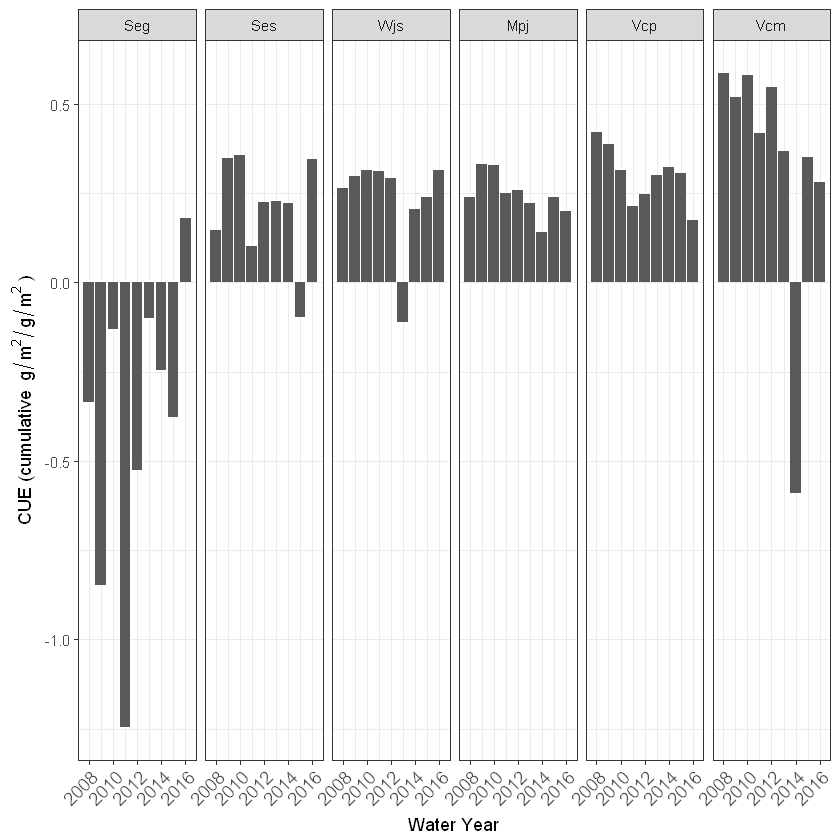

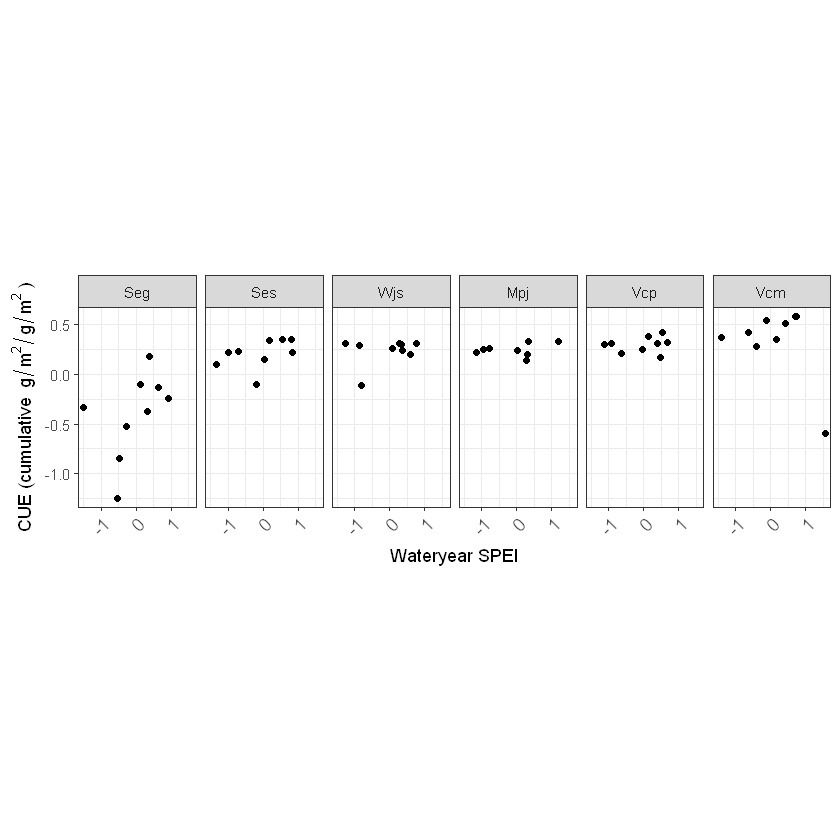

In [97]:
#CUE.m <- melt(clean_rename(CUE_daily), id.vars=c('season', 'year_w'))
#CUE.m <- ddply(CUE.m, .(variable, year_w), summarise, year_sum = sum(value, na.rm = T))
#head(CUE.m)
CUE.m$spei_seas <- spei_wyear_avg$seas_mean_spei
str(CUE.m)
# Merge in the annual values of SPEI
CUE.m <- merge(CUE.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
CUE.m <- CUE.m[with(CUE.m, order(variable,year_w)),]


CUE_seas_by_yr <- ggplot(CUE.m, aes(x=year_w, y=year_sum )) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Water Year') + ylab(bquote('CUE (cumulative '~ g/m^2/g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_x_continuous(breaks=seq(2008,2016,2))+
    scale_fill_date()
    theme(aspect.ratio=asp_ratio)
CUE_seas_by_yr

CUE_seas_by_annspei <- ggplot(CUE.m, aes(x=wyear_mean_spei, y=year_sum )) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('CUE (cumulative '~ g/m^2/g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    theme(aspect.ratio=asp_ratio)
CUE_seas_by_annspei

## Respiration to GPP

variable,season,year_w,seas_sum
Seg,Cold,2008,757.4834
Seg,Cold,2009,534.7019
Seg,Cold,2010,699.8692
Seg,Cold,2011,820.3678
Seg,Cold,2012,Inf
Seg,Cold,2013,915.9350


'data.frame':	162 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  757 535 700 820 Inf ...
 $ spei_seas: num  -1.411 -0.512 0.532 -0.208 -0.463 ...
'data.frame':	162 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ seas_sum       : num  636 415 580 700 Inf ...
 $ spei_seas      : num  -1.411 -0.512 0.532 -0.208 -0.463 ...
 $ wyear_mean_spei: num  -1.491 -0.48 0.649 -0.545 -0.282 ...


Warning message:
"Removed 1 rows containing missing values (geom_bar)."

Warning message:
"Removed 3 rows containing missing values (geom_point)."

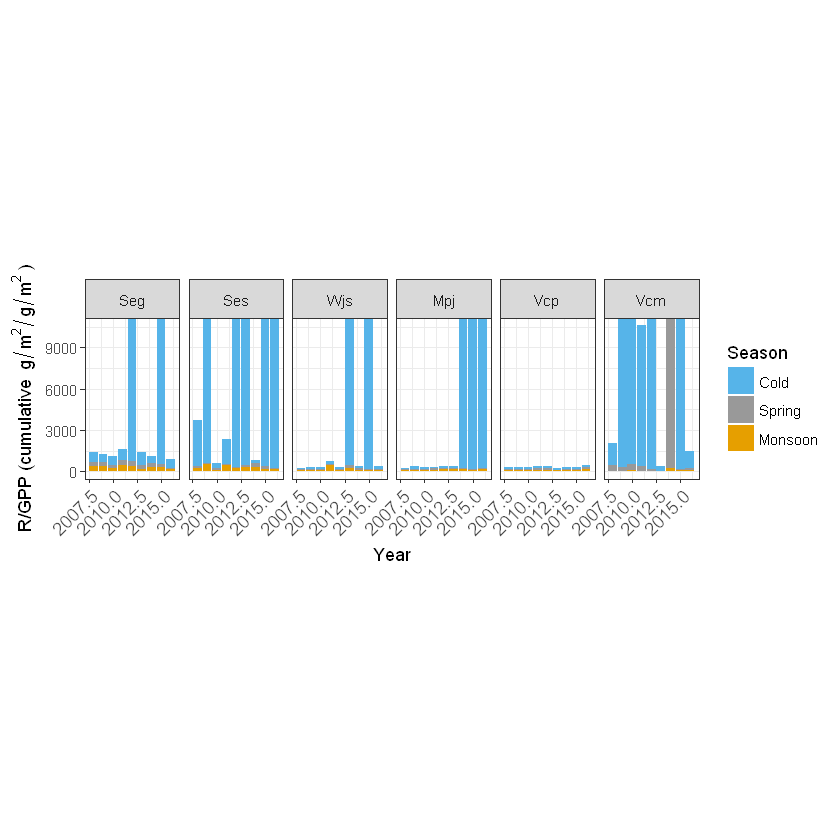

Warning message:
"Removed 3 rows containing missing values (geom_point)."

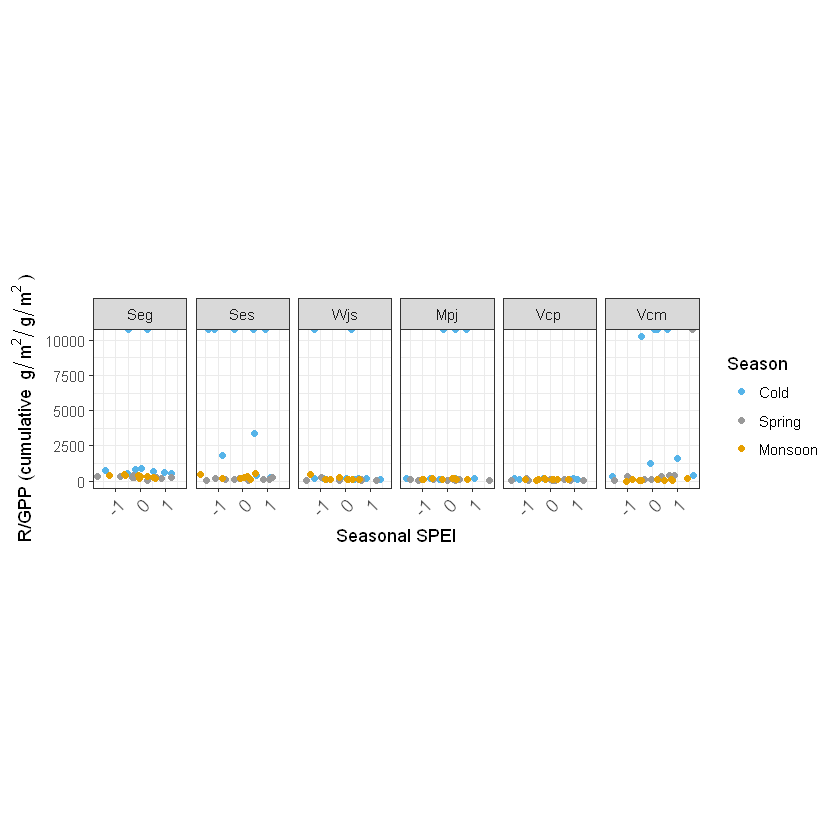

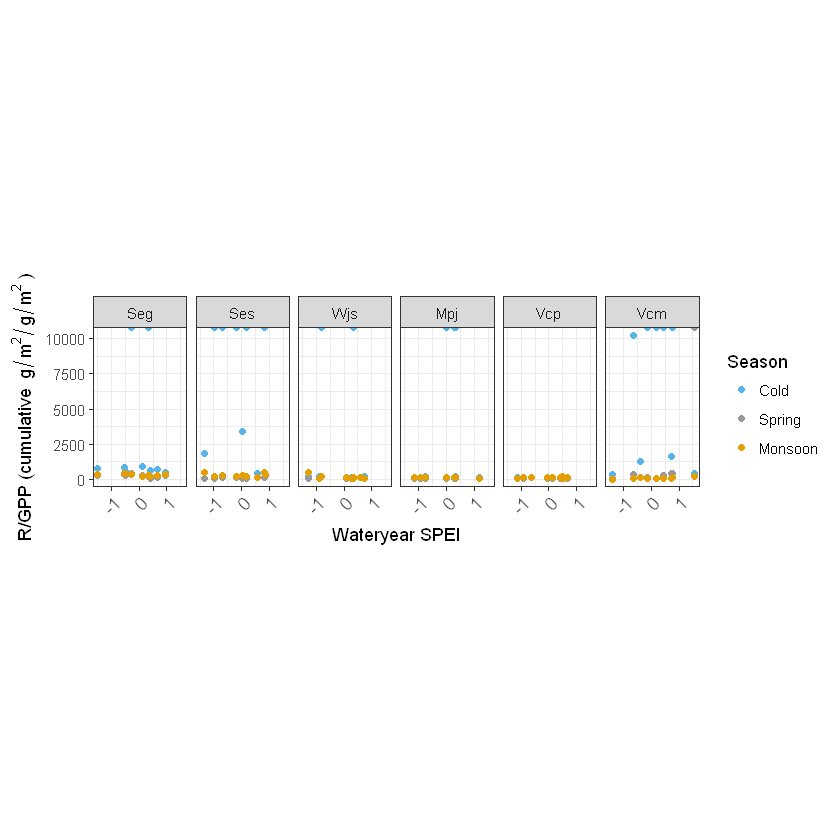

In [50]:
RdivGPP.m <- melt(clean_rename(RdivGPP_daily), id.vars=c( 'year_w'))
RdivGPP.m <- ddply(RdivGPP.m, .(variable, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(RdivGPP.m)
RdivGPP.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(RdivGPP.m)
# Merge in the annual values of SPEI
RdivGPP.m <- merge(RdivGPP.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
RdivGPP.m <- RdivGPP.m[with(RdivGPP.m, order(variable, season, year_w)),]
str(CUE.m)

RdivGPP_seas_by_yr <- ggplot(RdivGPP.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('R/GPP (cumulative '~ g/m^2/g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RdivGPP_seas_by_yr

RdivGPP_seas_by_spei <- ggplot(RdivGPP.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('R/GPP (cumulative '~ g/m^2/g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RdivGPP_seas_by_spei

RdivGPP_seas_by_annspei <- ggplot(RdivGPP.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('R/GPP (cumulative '~ g/m^2/g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RdivGPP_seas_by_annspei